In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from scipy.optimize import curve_fit
from scipy import stats

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, current_dir) 
import dataloader as dl
import bandpower
from Ginny_ERSP import preprocessing


# Import data

In [2]:
# Read pickle file
with open('./ERSP_from_raw.data', 'rb') as fp:
    dict_ERSP = pickle.load(fp)
    
ERSP, SLs, freq, t = dict_ERSP['ERSP'], dict_ERSP['SLs'], dict_ERSP['freq'], dict_ERSP['t']
print('Shape of ERSP: ', ERSP.shape)
print('Shape of SLs: ', SLs.shape)
print('Shape of freq: ', freq.shape)
print('Shape of t: ', t.shape)

Shape of ERSP:  (1084, 12, 57, 172)
Shape of SLs:  (1084,)
Shape of freq:  (57,)
Shape of t:  (172,)


# Regression

In [3]:
def standard_error(pred, target):
    
    assert pred.shape[0] == target.shape[0]
    
    return (np.sum( np.power(pred-target,2) )/len(pred))**0.5

def plot_scatter(true, pred):

    max_value = np.max(np.hstack((true, pred)))
    plt.scatter(true, pred, marker='.')
    axes = plt.gca()
    axes.set_xlim([0, max_value])
    axes.set_ylim([0, max_value])
    plt.xlabel('True')
    plt.ylabel('Pred')
    
def regression(X_train, Y_train, X_test, Y_test, regressor):
    
    results = regressor.fit(X_train,Y_train)
    pred_train = regressor.predict(X_train)
    pred_test = regressor.predict(X_test)
    
    train_std = mean_squared_error(Y_train, pred_train)**0.5
    test_std = mean_squared_error(Y_test, pred_test)**0.5
    train_r2 = r2_score(Y_train, pred_train)
    test_r2 = r2_score(Y_test, pred_test)
    
    return results, train_std, test_std, train_r2, test_r2, pred_train, pred_test

In [7]:
num_fold = 10
train_std = np.zeros(num_fold)
test_std = np.zeros(num_fold)
train_r2 = np.zeros(num_fold)
test_r2 = np.zeros(num_fold)
train_base = np.zeros(num_fold)
test_base = np.zeros(num_fold)
train_base_r2 = np.zeros(num_fold)
test_base_r2 = np.zeros(num_fold)

pred_Y = np.zeros(num_fold)

kf = KFold(n_splits=num_fold, shuffle=True)
method = 1
select = []

for i, (train_index, test_index) in enumerate(kf.split(ERSP)):
    print('---Iteration %d---\n'%(i))
    #print(test_index)
    
    # Standardize data
    X_all, Y = preprocessing.standardize(ERSP, SLs, train_indices=train_index)
    
    # Select correlated ERSP
    X_all, select_indices = preprocessing.select_correlated_ERSP(X_all, Y, threshold_corr=0.75, train_indices=train_index)
    select.append(select_indices)
    
    # Flatten X_all
    X_all = X_all.reshape((X_all.shape[0],-1))
    
    #X_all = preprocessing.bandpower(X_all, freqs, 5, 15)
    
    # Split data
    X_train, X_test = X_all[train_index, :], X_all[test_index, :]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    if method == 1:
        pca = PCA(n_components=0.9)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)
    elif method == 2:
        # PCA
        X_train, X_test = preprocessing.PCA_corr(X_train, Y_train, X_test=X_test)
    
    # 1. Regression directly
    #rgr = svm.SVR()
    #rgr = Ridge(alpha=1)
    rgr = LinearRegression()
    results, train_std[i], test_std[i], train_r2[i], test_r2[i], pred_train1, pred_test1 = regression(\
        X_train, Y_train, X_test, Y_test, rgr)
    print('Method 1: %f | %f\n'%(train_std[i], test_std[i]))
    #pred_Y[i] = pred_test1
    
    train_baseline = np.array([np.mean(Y_train)]*Y_train.shape[0])
    test_baseline = np.array([np.mean(Y_train)]*Y_test.shape[0])
    print('Baseline: %f | %f\n'%(standard_error(train_baseline, Y_train), standard_error(test_baseline, Y_test)))
    train_base[i] = standard_error(train_baseline, Y_train)
    test_base[i] = standard_error(test_baseline, Y_test)
    train_base_r2[i] = r2_score(Y_train, train_baseline)
    test_base_r2[i] = r2_score(Y_test, test_baseline)
    

---Iteration 0---

Select 171 features
Method 1: 16.265235 | 20.552573

Baseline: 17.896274 | 21.157681

---Iteration 1---

Select 171 features
Method 1: 16.748866 | 16.088400

Baseline: 18.555705 | 15.250920

---Iteration 2---

Select 171 features
Method 1: 16.913312 | 14.659246

Baseline: 18.468042 | 16.180008

---Iteration 3---

Select 171 features
Method 1: 16.802629 | 16.812388

Baseline: 18.446991 | 16.388198

---Iteration 4---

Select 171 features
Method 1: 16.566783 | 17.770581

Baseline: 18.209828 | 18.613296

---Iteration 5---

Select 171 features
Method 1: 16.658269 | 16.778119

Baseline: 18.443787 | 16.404359

---Iteration 6---

Select 171 features
Method 1: 16.461004 | 19.115271

Baseline: 18.027352 | 20.158069

---Iteration 7---

Select 171 features
Method 1: 16.586472 | 18.559853

Baseline: 18.182623 | 18.853071

---Iteration 8---

Select 171 features
Method 1: 16.579455 | 18.020520

Baseline: 18.240431 | 18.342218

---Iteration 9---

Select 171 features
Method 1: 16.372

In [8]:
print('Baseline : std (%.2f,%.2f), r2 (%.2f,%.2f)'%\
      (np.mean(train_base), np.mean(test_base), np.mean(train_base_r2), np.mean(test_base_r2)))
print('Method 1: std (%.2f,%.2f), r2 (%.2f,%.2f)'%(np.mean(train_std), np.mean(test_std), np.mean(train_r2), np.mean(test_r2)))

Baseline : std (18.25,18.16), r2 (0.00,-0.00)
Method 1: std (16.60,17.89), r2 (0.17,0.02)


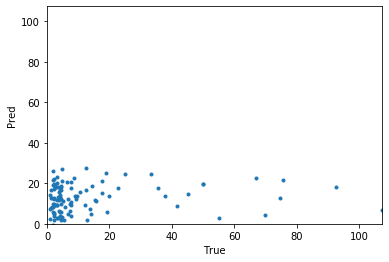

In [9]:
plot_scatter(Y_test, pred_test1)

In [23]:
ERSP.shape

(1084, 12, 57, 172)